In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [5]:
import os

# Specify the path to your dataset
fpath = "C:/Users/shikh/OneDrive/Desktop/apple_tomato/train"
dataset_path = fpath

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

# Create a list of target_names based on the directory names
target_names = class_folders
print("Target Names:", target_names)


Number of classes: 2
Target Names: ['apples', 'tomatoes']


In [13]:
img_size = 224
batch_size =50
fpath = "C:/Users/shikh/OneDrive/Desktop/apple_tomato/train"
ffpath="C:/Users/shikh/OneDrive/Desktop/apple_tomato/test"


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'fpath' is the path to your dataset and 'batch_size' is defined

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=30,
    validation_split=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    fpath,
    target_size=(224, 224),
    subset="training",
    class_mode='categorical',
    batch_size=batch_size
)

valid_gen = datagen.flow_from_directory(
    fpath,
    target_size=(224, 224),
    batch_size=(batch_size),
    subset='validation',
    class_mode='categorical'
)

# For test data
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    ffpath,
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 236 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
# Define filepath to save the best model
filepath = 'best_model.keras'  # Change from .h5 to .keras

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback

history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

D:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5157 - loss: 1.0613
Epoch 1: val_accuracy improved from -inf to 0.55172, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 171s 16s/step - accuracy: 0.5166 - loss: 1.0707 - val_accuracy: 0.5517 - val_loss: 0.7556
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6375 - loss: 1.1450
Epoch 2: val_accuracy did not improve from 0.55172
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.6337 - loss: 1.1721 - val_accuracy: 0.4483 - val_loss: 1.2563
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5180 - loss: 1.1317
Epoch 3: val_accuracy improved from 0.55172 to 0.56897, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 10s/step - accuracy: 0.5171 - loss: 1.1307 - val_accuracy: 0.5690 - val_loss: 0.7226
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6489 - loss: 0.9967
Epoch 4: val_accuracy did not improve from 0.56897
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.6467 -

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.keras')

train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.7192 - loss: 0.6723
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5660 - loss: 0.6844
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.6528 - loss: 0.6801
Train Loss:  0.6731961965560913
Train Accuracy:  0.6991525292396545
--------------------
Validation Loss:  0.684337854385376
Validation Accuracy:  0.568965494632721
--------------------
Test Loss:  0.679335355758667
Test Accuracy:  0.6391752362251282


In [27]:

model = load_model('best_model.keras')

# Predict using the updated method
preds = model.predict(test_gen)  # Use `predict` instead of `predict_generator`
y_pred = np.argmax(preds, axis=1)

# Print predicted labels
print(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 25s/step
[1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1]


In [29]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[37 17]
 [18 25]]
              precision    recall  f1-score   support

      apples       0.67      0.69      0.68        54
    tomatoes       0.60      0.58      0.59        43

    accuracy                           0.64        97
   macro avg       0.63      0.63      0.63        97
weighted avg       0.64      0.64      0.64        97



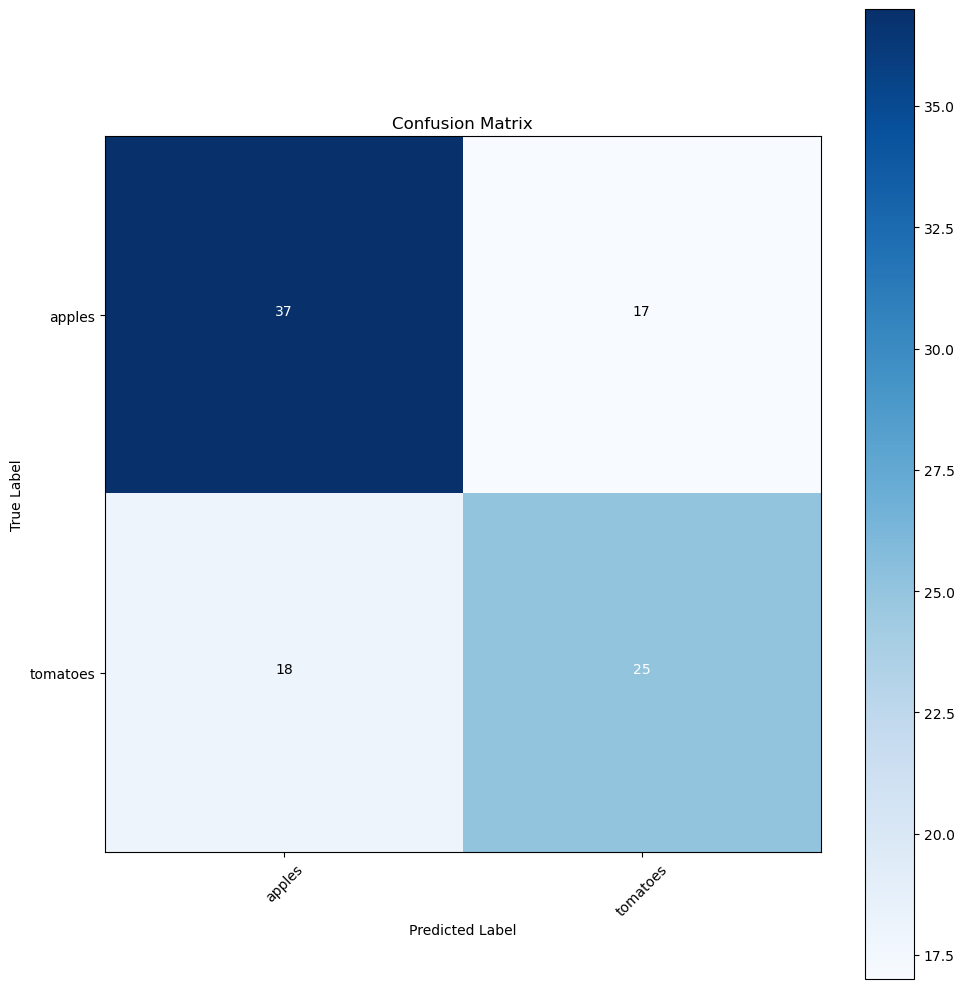

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5780 - loss: 0.8550 
Epoch 1: val_accuracy improved from -inf to 0.60345, saving model to best_model_resnet.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 120s 17s/step - accuracy: 0.5784 - loss: 0.8601 - val_accuracy: 0.6034 - val_loss: 0.7188
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6739 - loss: 0.6135 
Epoch 2: val_accuracy did not improve from 0.60345
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 13s/step - accuracy: 0.6795 - loss: 0.6043 - val_accuracy: 0.5862 - val_loss: 0.6760
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7060 - loss: 0.5368 
Epoch 3: val_accuracy did not improve from 0.60345
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 13s/step - accuracy: 0.7105 - loss: 0.5334 - val_accuracy: 0.5517 - val_loss: 1.0039
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7361 - loss: 0.5847 
Epoch 4: val_accuracy did not improve from 0.60345
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 13s/step - accuracy: 0.7370 - loss: 0.5820 - val_acc

In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.keras')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.6352 - loss: 0.6409
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6138 - loss: 0.6926
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.7397 - loss: 0.5005
Train Loss:  0.6367223262786865
Train Accuracy:  0.6398305296897888
--------------------
Validation Loss:  0.6958842873573303
Validation Accuracy:  0.6206896305084229
--------------------
Test Loss:  0.5969865918159485
Test Accuracy:  0.6494845151901245


In [41]:
model = load_model('best_model_resnet.keras')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 18s/step
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]


Confusion Matrix, Without Normalization
[[50  4]
 [30 13]]
              precision    recall  f1-score   support

      apples       0.62      0.93      0.75        54
    tomatoes       0.76      0.30      0.43        43

    accuracy                           0.65        97
   macro avg       0.69      0.61      0.59        97
weighted avg       0.69      0.65      0.61        97



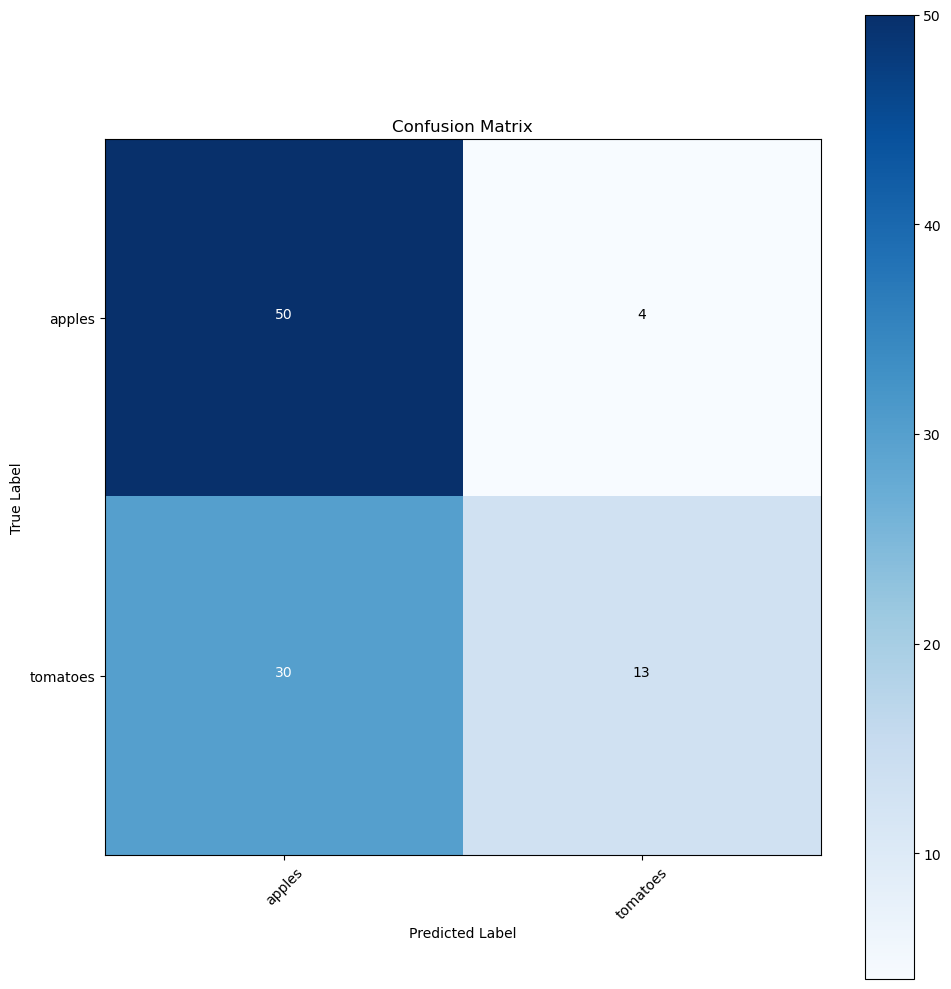

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.keras'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.6079 - loss: 1.0404 
Epoch 1: val_accuracy improved from -inf to 0.53448, saving model to best_model_vgg.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 204s 39s/step - accuracy: 0.6132 - loss: 1.0245 - val_accuracy: 0.5345 - val_loss: 1.0635
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8154 - loss: 0.5134 
Epoch 2: val_accuracy improved from 0.53448 to 0.67241, saving model to best_model_vgg.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 186s 41s/step - accuracy: 0.8201 - loss: 0.5057 - val_accuracy: 0.6724 - val_loss: 0.7121
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8231 - loss: 0.3438 
Epoch 3: val_accuracy improved from 0.67241 to 0.70690, saving model to best_model_vgg.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 185s 40s/step - accuracy: 0.8251 - loss: 0.3428 - val_accuracy: 0.7069 - val_loss: 0.6022
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7933 - loss: 0.4859 
Epoch 4: val_accuracy improved from 0.70690 to 

In [53]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_vgg.keras')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 16s/step - accuracy: 0.9732 - loss: 0.1018
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8614 - loss: 0.4143
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 17s/step - accuracy: 0.8438 - loss: 0.3855
Train Loss:  0.10201248526573181
Train Accuracy:  0.9703390002250671
--------------------
Validation Loss:  0.4102042317390442
Validation Accuracy:  0.8620689511299133
--------------------
Test Loss:  0.3749975562095642
Test Accuracy:  0.8556700944900513


In [55]:
model = load_model('best_model_vgg.keras')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018A2464DA80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 17s/step
[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1]


Confusion Matrix, Without Normalization
[[45  9]
 [ 5 38]]
              precision    recall  f1-score   support

      apples       0.90      0.83      0.87        54
    tomatoes       0.81      0.88      0.84        43

    accuracy                           0.86        97
   macro avg       0.85      0.86      0.85        97
weighted avg       0.86      0.86      0.86        97



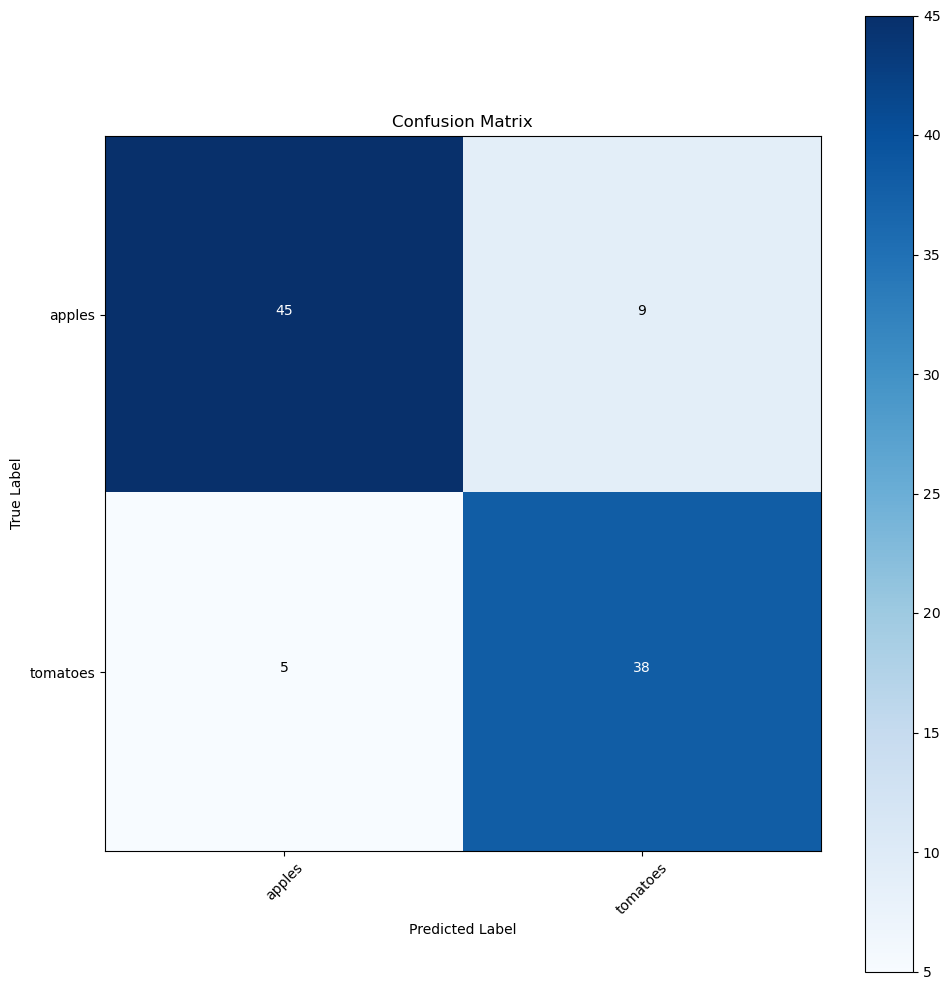

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))